In [1]:
import sys

import tensorflow.keras
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.3.0
Keras Version: 2.4.0

Python 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
GPU is available


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

In [4]:
print(np.__version__)

1.18.5


In [5]:
import matplotlib
print(matplotlib.__version__)

3.3.4


In [3]:
import pathlib
data_dir = pathlib.Path('Data')
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1928


In [4]:
batch_size = 16
img_height = 430
img_width = 430

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1928 files belonging to 3 classes.
Using 1350 files for training.


In [6]:
print(len(train_ds))

85


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1928 files belonging to 3 classes.
Using 578 files for validation.


In [8]:
print(len(val_ds))

37


In [9]:
class_names = train_ds.class_names
print(class_names)

['First', 'Second', 'Third']


(16, 430, 430, 3)
(16,)


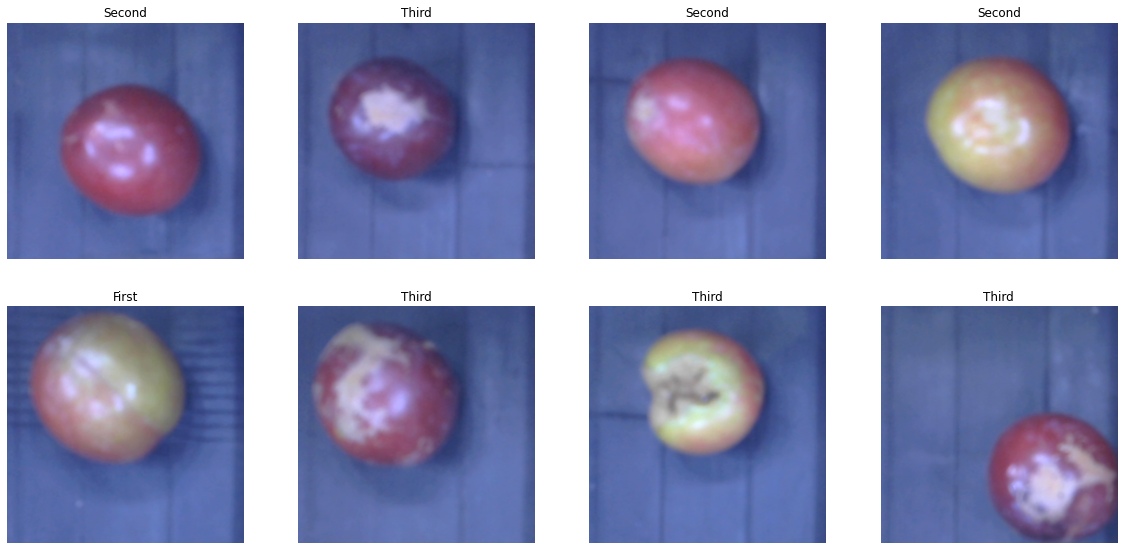

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.17254902 1.0


In [13]:
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 430, 430, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 430, 430, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 215, 215, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 215, 215, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 107, 107, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 107, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 32)        0

In [16]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
85/85 [==============================] - 43s 509ms/step - loss: 0.9635 - accuracy: 0.5356 - val_loss: 0.8286 - val_accuracy: 0.6367
Epoch 2/30
85/85 [==============================] - 41s 484ms/step - loss: 0.7990 - accuracy: 0.6556 - val_loss: 0.6645 - val_accuracy: 0.7318
Epoch 3/30
85/85 [==============================] - 23s 272ms/step - loss: 0.6245 - accuracy: 0.7348 - val_loss: 0.5235 - val_accuracy: 0.7785
Epoch 4/30
85/85 [==============================] - 30s 356ms/step - loss: 0.5294 - accuracy: 0.7807 - val_loss: 0.5434 - val_accuracy: 0.7958
Epoch 5/30
85/85 [==============================] - 31s 366ms/step - loss: 0.4331 - accuracy: 0.8207 - val_loss: 0.4722 - val_accuracy: 0.8166
Epoch 6/30
85/85 [==============================] - 23s 271ms/step - loss: 0.4607 - accuracy: 0.8200 - val_loss: 0.4546 - val_accuracy: 0.8183
Epoch 7/30
85/85 [==============================] - 23s 270ms/step - loss: 0.3904 - accuracy: 0.8467 - val_loss: 0.4562 - val_accuracy: 0.8183

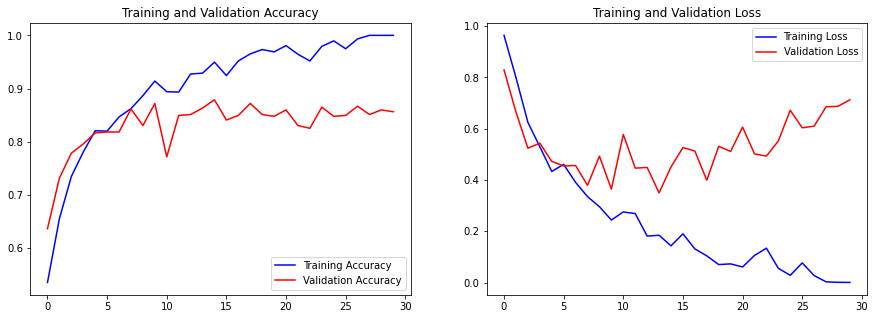

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,'b-', label='Training Accuracy')
plt.plot(epochs_range, val_acc,'r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,'b-', label='Training Loss')
plt.plot(epochs_range, val_loss,'r', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

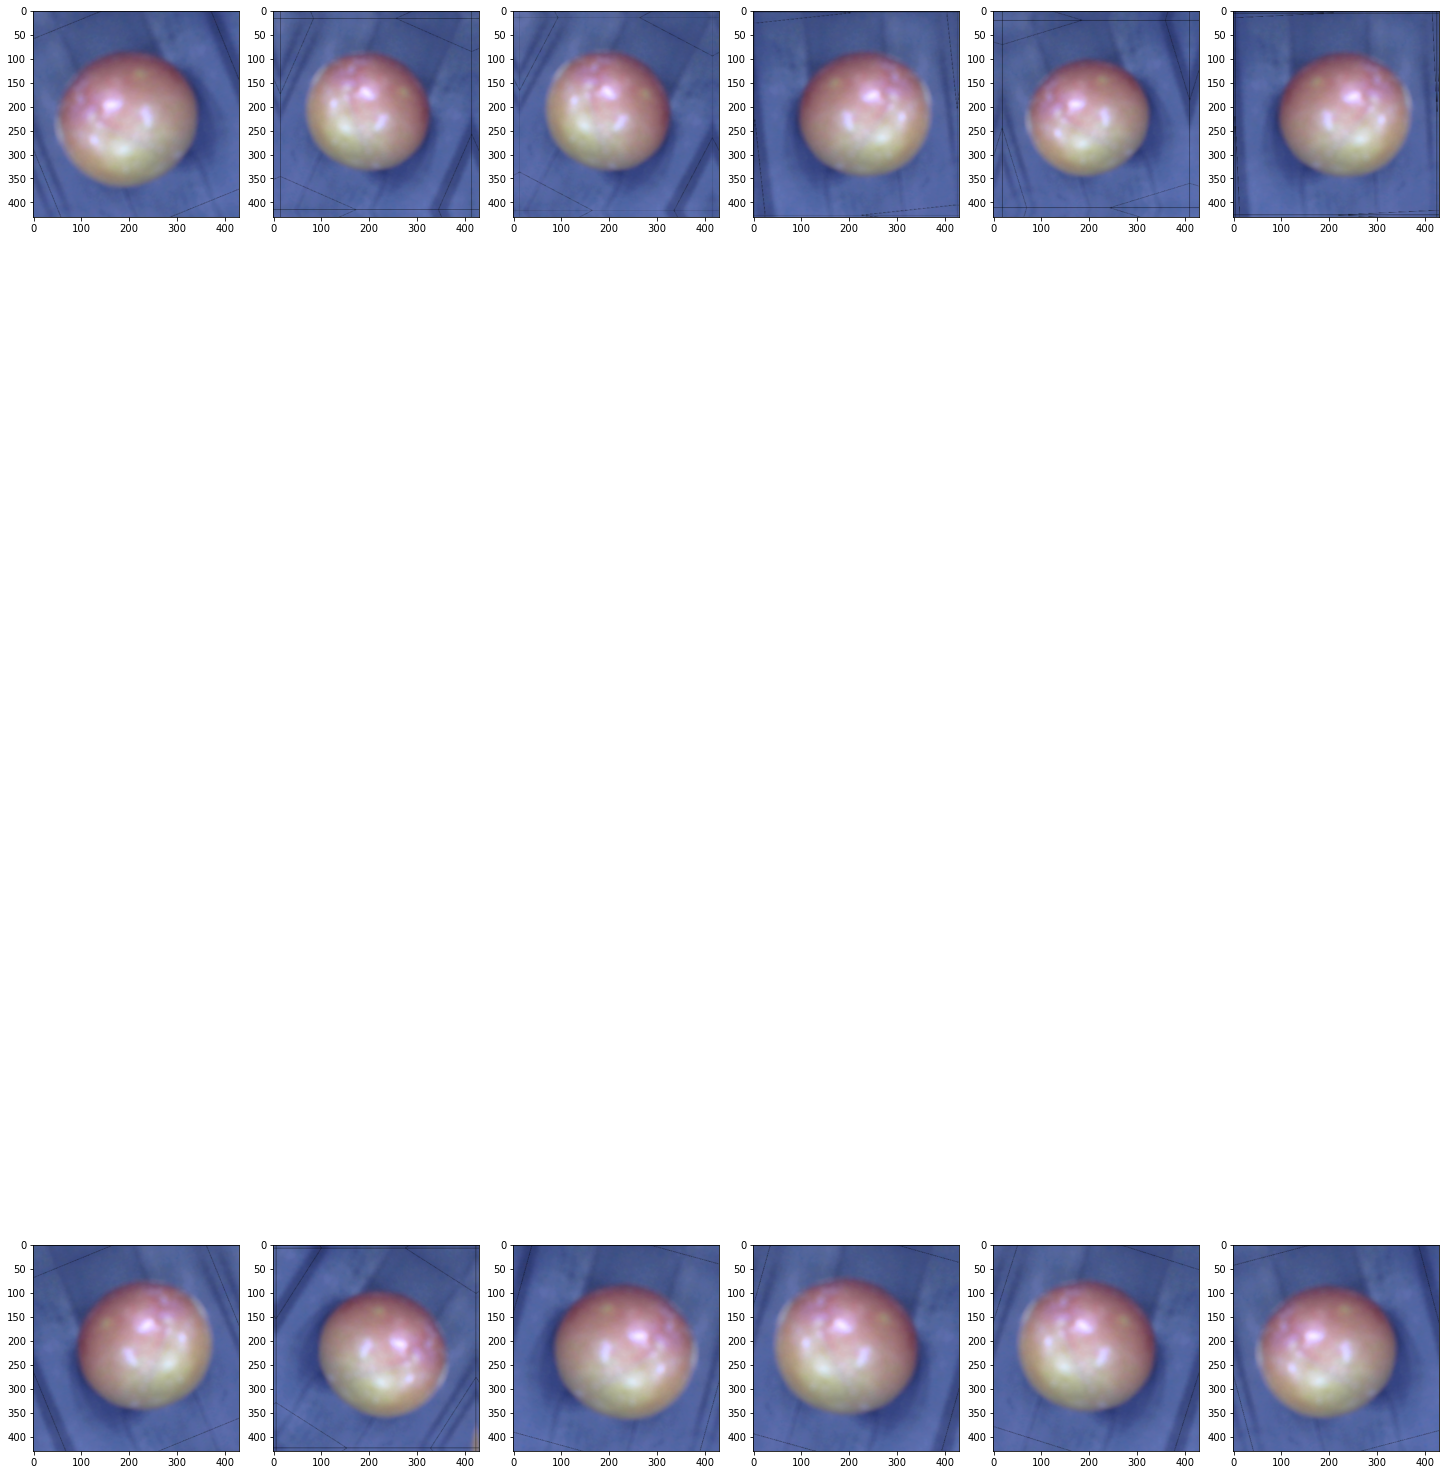

In [19]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(wspace=0, hspace=5, left=0, right=1, bottom=0, top=1)
for images, _ in train_ds.take(1):
    for i in range(12):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(2, 6, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))


In [20]:
num_classes = 3
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
 # layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 430, 430, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 430, 430, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 430, 430, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 215, 215, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 215, 215, 16)      2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 107, 107, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 107, 107, 32)     

In [23]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
85/85 [==============================] - 25s 289ms/step - loss: 1.0325 - accuracy: 0.4563 - val_loss: 1.5084 - val_accuracy: 0.3789
Epoch 2/30
85/85 [==============================] - 24s 287ms/step - loss: 0.9860 - accuracy: 0.5059 - val_loss: 0.8660 - val_accuracy: 0.6055
Epoch 3/30
85/85 [==============================] - 24s 286ms/step - loss: 0.8500 - accuracy: 0.5985 - val_loss: 0.6765 - val_accuracy: 0.7145
Epoch 4/30
85/85 [==============================] - 24s 287ms/step - loss: 0.7672 - accuracy: 0.6622 - val_loss: 0.8074 - val_accuracy: 0.6090
Epoch 5/30
85/85 [==============================] - 24s 285ms/step - loss: 0.6436 - accuracy: 0.7148 - val_loss: 0.4648 - val_accuracy: 0.8270
Epoch 6/30
85/85 [==============================] - 24s 286ms/step - loss: 0.6647 - accuracy: 0.7156 - val_loss: 0.6413 - val_accuracy: 0.7405
Epoch 7/30
85/85 [==============================] - 24s 286ms/step - loss: 0.6379 - accuracy: 0.7430 - val_loss: 0.4999 - val_accuracy: 0.7889

In [33]:
target_dir = './modelo/'
if not os.path.exists(target_dir):
    os.mkdir(target_dir)
model.save('./modelo/modelo.h5')
model.save_weights('./modelo/pesos.h5')



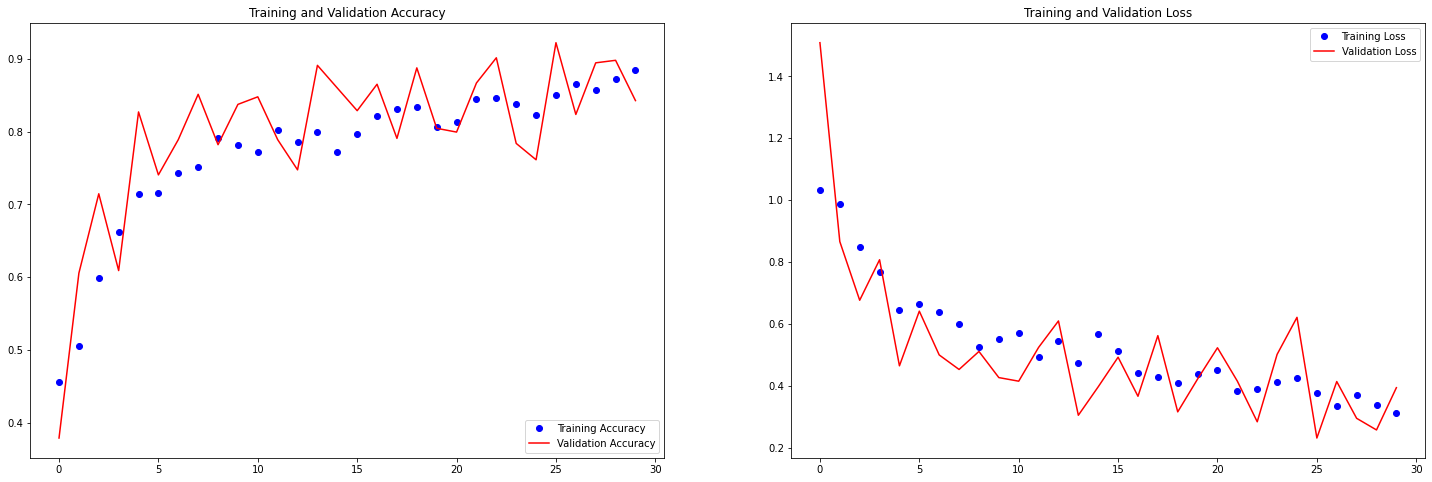

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(25, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,'bo', label='Training Accuracy')
plt.plot(epochs_range, val_acc,'r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss,'bo', label='Training Loss')
plt.plot(epochs_range, val_loss,'r', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
j=1
x_ax=['Primera','Segunda','Tercera']
for j in range(1,4):
    img = keras.preprocessing.image.load_img(
    str(str(j)+'.jpg'), target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    print(predictions)
    score = tf.nn.softmax(predictions[0])
    print(score)
    if j<=4:
        plt.figure(figsize=(20, 20))
        ps=2*j+1
        ax = plt.subplot(4, 2,ps)
        plt.imshow(img)
        plt.axis("off")
        shd=plt.subplot(4,2,ps+1)
        shd.set_ylim([0,1])
        shd.bar(x_ax,score,color='red')
        shd.set_title('CNN')

In [36]:
for l in range(1,4):
    img = keras.preprocessing.image.load_img(
    str(str(l)+'.png'), target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(str(l)+" This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))



1 This image most likely belongs to Primera with a 99.71 percent confidence.
2 This image most likely belongs to Segunda with a 97.87 percent confidence.
3 This image most likely belongs to Tercera with a 99.97 percent confidence.


In [42]:
class_names[np.argmax(score)]

'Tercera'

In [51]:
target_dir = './modelo/'
if not os.path.exists(target_dir):
    os.mkdir(target_dir)
model.save('./modelo/modelo.h5')
model.save_weights('./modelo/pesos.h5')
